In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Note: This script was run on kaggle. Hence the need for all these initial steps**

In [2]:
#Setup Gdrive file download extention 
!conda install -y gdown

Retrieving notices: ...working... done
Channels:
 - rapidsai
 - nvidia
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2024.8.30  |       hbcca054_0         155 KB  conda-forge
    certifi-2024.8.30          |     pyhd8ed1ab_0         160 KB  conda-forge
    conda-24.7.1               |  py310hff52083_0         940 KB  conda-forge
    filelock-3.16.0            |     pyhd8ed1ab_0          17 KB  conda-forge
    gdown-5.2.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    libgcc-14.1.0              |       h77fa898_1         827 KB  conda-forge
    libgcc-ng-14.1.0           |       h69a702a_1          51 KB  conda-forge
    libgomp-14.1.0             |       h77fa898_1         449 KB  conda

In [3]:
#https://drive.google.com/file/d/1XI9ryAvJ6DNmNHeqGmpeUtKK1_drZ8im/view?usp=drive_link

In [4]:
#https://drive.google.com/file/d/19U1WW_vDnHblRfLOnJIik5mqc4Gd8hGV/view?usp=sharing
!gdown --id 1XI9ryAvJ6DNmNHeqGmpeUtKK1_drZ8im

/opt/conda/lib/python3.10/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1XI9ryAvJ6DNmNHeqGmpeUtKK1_drZ8im
From (redirected): https://drive.google.com/uc?id=1XI9ryAvJ6DNmNHeqGmpeUtKK1_drZ8im&confirm=t&uuid=9c63a16d-8224-43d5-a00e-609a2d3f80fa
To: /kaggle/working/Gorilla Project.zip
100%|█████████████████████████████████████████| 350M/350M [00:02<00:00, 147MB/s]


In [5]:
import zipfile

zip_file_path = '/kaggle/working/Gorilla Project.zip'  # replace with the name of your downloaded zip file
extract_path = '/kaggle/working/unzipped_folder'  # replace with your desired extract path

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Files extracted to {extract_path}")

Files extracted to /kaggle/working/unzipped_folder


**The main code starts here**

In [6]:
import numpy as np
import librosa
import os
import soundfile as sf
import matplotlib.pyplot as plt
import pandas as pd
import librosa
import torch
from transformers import Wav2Vec2Model, Wav2Vec2Processor

In [34]:
def extract_gorilla_segments_from_excel(excel_file_path, audio_files_dir, segment_length=None):
    # Load Excel file
    excel_data = pd.ExcelFile(excel_file_path)

    # Initialize dictionaries to store segments and labels
    segments_dict = {}
    labels_dict = {}
    max_segment_length = 0  # Initialize maximum segment length

    # Iterate over each sheet in the Excel file
    for sheet_name in excel_data.sheet_names:
        # Extract common part of the audio file name from sheet name
        common_part = sheet_name.split('_')[0]

        # Find audio file matching the common part
        audio_file_name = None
        for file_name in os.listdir(audio_files_dir):
            if common_part in file_name:
                audio_file_name = os.path.splitext(file_name)[0]
                break

        # Skip if corresponding audio file not found
        if audio_file_name is None:
            print(f"Audio file not found for sheet '{sheet_name}'. Skipping...")
            continue

        # Load audio
        audio_file_path = os.path.join(audio_files_dir, f"{audio_file_name}.wav")
        y, sr = librosa.load(audio_file_path, sr=None, mono=True)

        # Read selection table from current sheet
        selection_table = excel_data.parse(sheet_name)

        # Initialize lists to store segments and labels
        segments = []
        labels = []

        # Iterate over rows in the selection table
        for index, row in selection_table.iterrows():
            # Extract relevant information
            begin_time = row['Begin Time (s)']
            end_time = row['End Time (s)']
            label = row['Gorilla Sound']

            # Convert time to samples
            begin_sample = int(begin_time * sr)
            end_sample = int(end_time * sr)

            # Determine segment length
            if segment_length is None:
                segment_length = end_sample - begin_sample
            else:
                max_segment_length = max(max_segment_length, end_sample - begin_sample)  # Update max segment length

            # Extract segment and pad or truncate to segment_length
            segment = y[begin_sample:end_sample]
            padded_segment = np.zeros(segment_length)
            padded_segment[:min(len(segment), segment_length)] = segment[:min(len(segment), segment_length)]

            # Append padded segment and label to lists
            segments.append(padded_segment)
            labels.append(label)

        # Store segments and labels in dictionaries
        segments_dict[audio_file_name] = segments
        labels_dict[audio_file_name] = labels

    return segments_dict, labels_dict, max_segment_length

In [35]:
# Example usage
excel_file_path = '/kaggle/working/unzipped_folder/input_dir/Selections/GORILLA SELECTIONSS.xlsx'
audio_files_dir = '/kaggle/working/unzipped_folder/input_dir/Gorilla Sounds'
segments_dict, labels_dict, max_segment_length = extract_gorilla_segments_from_excel(excel_file_path, audio_files_dir)

# Print the maximum segment length
print("Maximum segment length:", max_segment_length)

Maximum segment length: 281092


In [9]:
# Function to pad or truncate a segment
def pad_or_truncate(segment, target_length):
    if len(segment) > target_length:
        return segment[:target_length]
    else:
        return np.pad(segment, (0, target_length - len(segment)), 'constant')

# Determine the target length (maximum length of all segments)
max_length = max(max(len(segment) for segment in segments) for segments in segments_dict.values())

# Pad or truncate all segments to the target length
padded_segments_dict = {}
for audio_file_name, segments in segments_dict.items():
    padded_segments = [pad_or_truncate(segment, max_length) for segment in segments]
    padded_segments_dict[audio_file_name] = np.array(padded_segments)

# Convert segments and labels to arrays
all_segments = np.concatenate(list(padded_segments_dict.values()), axis=0)
all_labels = np.concatenate(list(labels_dict.values()), axis=0)

# Check the shapes of the resulting arrays
print("Shape of all_segments:", all_segments.shape)
print("Shape of all_labels:", all_labels.shape)

# Now all_segments and all_labels can be used for building a CNN model

Shape of all_segments: (354, 17061)
Shape of all_labels: (354,)


In [10]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification, Trainer, TrainingArguments

from sklearn.model_selection import train_test_split

2024-09-12 09:21:34.557996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-12 09:21:34.558134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-12 09:21:34.727182: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [13]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import Wav2Vec2Processor, Wav2Vec2ForSequenceClassification
from sklearn.model_selection import train_test_split

# Define the device (use GPU if available, otherwise use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, audio_data, labels, processor, sampling_rate=16000):
        self.audio_data = audio_data
        self.labels = labels
        self.processor = processor
        self.sampling_rate = sampling_rate

    def __len__(self):
        return len(self.audio_data)

    def __getitem__(self, idx):
        audio = self.audio_data[idx]
        label = self.labels[idx]
        if audio.ndim == 2:
            audio = audio.squeeze(0)
        inputs = self.processor(audio, sampling_rate=self.sampling_rate, return_tensors="pt", padding=True)
        inputs['labels'] = torch.tensor(label, dtype=torch.long)
        return {'input_values': inputs['input_values'].squeeze(0), 'labels': inputs['labels']}

# Load pre-trained Wav2Vec2 processor and model
processor = Wav2Vec2Processor.from_pretrained("facebook/wav2vec2-base-960h")
num_labels = 2  # Set to the number of your classes, e.g., 0 and 1
model = Wav2Vec2ForSequenceClassification.from_pretrained("facebook/wav2vec2-base-960h", num_labels=num_labels)

# Move the model to the specified device
model.to(device)

# Placeholder data (replace with actual data)
all_segments = all_segments
all_labels = all_labels

# Split data into training and test sets
train_data, test_data, train_labels, test_labels = train_test_split(all_segments, all_labels, test_size=0.2, random_state=42)

# Split training data into training and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Create dataset objects from your data
train_dataset = CustomDataset(train_data, train_labels, processor)
val_dataset = CustomDataset(val_data, val_labels, processor)
test_dataset = CustomDataset(test_data, test_labels, processor)


# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

def extract_features(dataloader):
    all_features = []
    all_labels = []
    for batch in dataloader:
        inputs = {key: value.to(device) for key, value in batch.items() if key != 'labels'}
        labels = batch['labels'].to(device)
        with torch.no_grad():
            # Extract hidden states
            outputs = model(**inputs, output_hidden_states=True)
            hidden_states = outputs.hidden_states  # List of hidden states from each layer
            
            # Example: Use the last hidden state (or aggregate multiple states)
            features = hidden_states[-1].mean(dim=1).cpu().numpy()  # Averaging across time steps
        all_features.append(features)
        all_labels.append(labels.cpu().numpy())
    return np.vstack(all_features), np.hstack(all_labels)


# Extract features
train_features, train_labels = extract_features(train_loader)
val_features, val_labels = extract_features(val_loader)
test_features, test_labels = extract_features(test_loader)

# Verify shapes
print("Train features shape:", train_features.shape)
print("Train labels shape:", train_labels.shape)
print("Validation features shape:", val_features.shape)
print("Validation labels shape:", val_labels.shape)
print("Test features shape:", test_features.shape)
print("Test labels shape:", test_labels.shape)

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train features shape: (226, 768)
Train labels shape: (226,)
Validation features shape: (57, 768)
Validation labels shape: (57,)
Test features shape: (71, 768)
Test labels shape: (71,)


In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def wave_unet(input_shape, dropout_rate=0.5, l2_reg=1e-4):  # Adjust input_shape based on your data
    inputs = layers.Input(shape=input_shape)

    # Encoder
    conv1 = layers.Conv1D(64, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv1D(64, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Dropout(dropout_rate)(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(conv1)

    conv2 = layers.Conv1D(128, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv1D(128, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Dropout(dropout_rate)(conv2)
    pool2 = layers.MaxPooling1D(pool_size=2)(conv2)

    conv3 = layers.Conv1D(256, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv1D(256, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Dropout(dropout_rate)(conv3)
    pool3 = layers.MaxPooling1D(pool_size=2)(conv3)

    # Bottleneck
    conv4 = layers.Conv1D(512, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(pool3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv1D(512, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(conv4)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Dropout(dropout_rate)(conv4)

    # Decoder
    up5 = layers.Conv1DTranspose(256, 16, strides=2, padding='same')(conv4)
    if up5.shape[1] > conv3.shape[1]:
        up5 = layers.Cropping1D(cropping=((0, up5.shape[1] - conv3.shape[1])))(up5)
    elif up5.shape[1] < conv3.shape[1]:
        up5 = layers.ZeroPadding1D(padding=(0, conv3.shape[1] - up5.shape[1]))(up5)
    up5 = layers.concatenate([up5, conv3], axis=-1)
    conv5 = layers.Conv1D(256, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(up5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv1D(256, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(conv5)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Dropout(dropout_rate)(conv5)

    up6 = layers.Conv1DTranspose(128, 16, strides=2, padding='same')(conv5)
    if up6.shape[1] > conv2.shape[1]:
        up6 = layers.Cropping1D(cropping=((0, up6.shape[1] - conv2.shape[1])))(up6)
    elif up6.shape[1] < conv2.shape[1]:
        up6 = layers.ZeroPadding1D(padding=(0, conv2.shape[1] - up6.shape[1]))(up6)
    up6 = layers.concatenate([up6, conv2], axis=-1)
    conv6 = layers.Conv1D(128, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(up6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv1D(128, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(conv6)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Dropout(dropout_rate)(conv6)

    up7 = layers.Conv1DTranspose(64, 16, strides=2, padding='same')(conv6)
    if up7.shape[1] > conv1.shape[1]:
        up7 = layers.Cropping1D(cropping=((0, up7.shape[1] - conv1.shape[1])))(up7)
    elif up7.shape[1] < conv1.shape[1]:
        up7 = layers.ZeroPadding1D(padding=(0, conv1.shape[1] - up7.shape[1]))(up7)
    up7 = layers.concatenate([up7, conv1], axis=-1)
    conv7 = layers.Conv1D(64, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(up7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Conv1D(64, 16, activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))(conv7)
    conv7 = layers.BatchNormalization()(conv7)
    conv7 = layers.Dropout(dropout_rate)(conv7)

    # Single output per time series
    outputs = layers.GlobalAveragePooling1D()(conv7)
    outputs = layers.Dense(1, activation='sigmoid')(outputs)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

# Wave-Unet function with BatchNorm, Dropout, and L2 regularization
model = wave_unet(input_shape=(768, 1))

# Compile the model
model.compile(
    optimizer='adam',                      # Optimizer
    loss='binary_crossentropy',            # Loss function
    metrics=['accuracy']                   # Metrics to track
)

# Print model summary to verify
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 768, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_35 (Conv1D)  │ (None, 768, 64)   │      1,088 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768, 64)   │        256 │ conv1d_35[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_36 (Conv1D)  │ (None, 768, 64)   │     65,600 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 768, 64)   │        256 │ conv1d_36[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768, 64)   │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_9     │ (None, 384, 64)   │          0 │ dropout[0][0]     │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_37 (Conv1D)  │ (None, 384, 128)  │    131,200 │ max_pooling1d_9[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 128)  │        512 │ conv1d_37[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_38 (Conv1D)  │ (None, 384, 128)  │    262,272 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 384, 128)  │        512 │ conv1d_38[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 384, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_10    │ (None, 192, 128)  │          0 │ dropout_1[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_39 (Conv1D)  │ (None, 192, 256)  │    524,544 │ max_pooling1d_10… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256)  │      1,024 │ conv1d_39[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_40 (Conv1D)  │ (None, 192, 256)  │  1,048,832 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 192, 256)  │      1,024 │ conv1d_40[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 192, 256)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_11    │ (None, 96, 256)   │          0 │ dropout_2[0][0]   │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_41 (Conv1D)  │ (None, 96, 512)   │  2,097,664 │ max_pooling1d_11

 Total params: 15,219,969 (58.06 MB)

 Trainable params: 15,214,337 (58.04 MB)

 Non-trainable params: 5,632 (22.00 KB)

In [32]:
# Verify shapes of extracted features
print("Train features shape:", train_features.shape)  # Expecting (num_samples, feature_dim)
print("Train labels shape:", train_labels.shape)
print("Eval features shape:", val_features.shape)
print("Eval labels shape:", val_labels.shape)


Train features shape: (226, 768)
Train labels shape: (226,)
Eval features shape: (57, 768)
Eval labels shape: (57,)


Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 3s/step - accuracy: 0.5055 - loss: 0.9920 - val_accuracy: 0.6491 - val_loss: 124.3900 - learning_rate: 0.0010
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.5873 - loss: 0.9762 - val_accuracy: 0.6491 - val_loss: 1747.2555 - learning_rate: 0.0010
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.5504 - loss: 0.9929 - val_accuracy: 0.3509 - val_loss: 308.6107 - learning_rate: 0.0010
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.5256 - loss: 0.9962 - val_accuracy: 0.3509 - val_loss: 44.8699 - learning_rate: 0.0010
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.6033 - loss: 0.9595 - val_accuracy: 0.3509 - val_loss: 15.9660 - learning_rate: 0.0010
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 42s 3s/step - accuracy: 0.6198 - loss: 0.9271 - val_accuracy: 0.3509 - val_loss: 14.0490 - learning_rate: 0.0010
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.5783 - loss: 0.9227 - val_

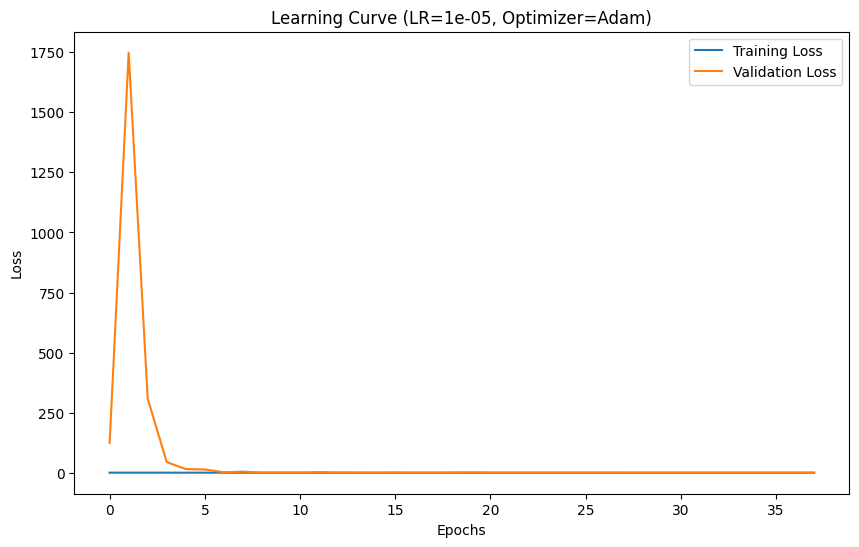

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 859ms/step - accuracy: 0.6153 - loss: 0.8299
Learning Rate: 1e-05, Optimizer: Adam, Test Loss: 0.8374335765838623, Test Accuracy: 0.6056337952613831
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step
Accuracy: 0.6056338028169014
Precision: 0.6119402985074627
Recall: 0.9534883720930233
F1 Score: 0.7454545454545454
Confusion Matrix:
[[ 2 26]
 [ 2 41]]
Epoch 1/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.5922 - loss: 0.8055 - val_accuracy: 0.6140 - val_loss: 0.8260 - learning_rate: 1.6000e-06
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.6196 - loss: 0.7871 - val_accuracy: 0.6316 - val_loss: 0.8227 - learning_rate: 1.6000e-06
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.6105 - loss: 0.7910 - val_accuracy: 0.6316 - val_loss: 0.8199 - learning_rate: 1.6000e-06
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.6654 - loss: 0.7979 - val_accuracy: 0.6491 - val_loss: 0.8178 - learning_rate: 1.6000e-06
Epoch 5/50
15/15 ━━

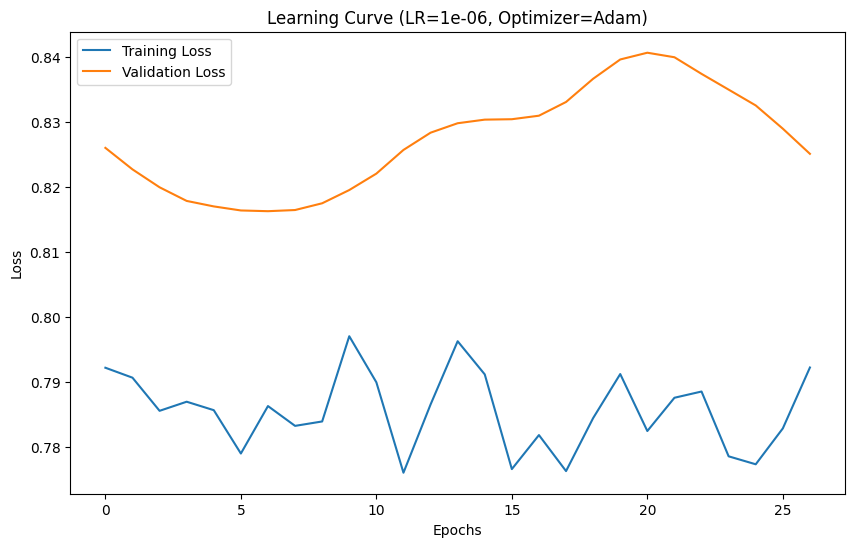

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 894ms/step - accuracy: 0.6192 - loss: 0.8243
Learning Rate: 1e-06, Optimizer: Adam, Test Loss: 0.8339391350746155, Test Accuracy: 0.6056337952613831
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 905ms/step
Accuracy: 0.6056338028169014
Precision: 0.6056338028169014
Recall: 1.0
F1 Score: 0.7543859649122806
Confusion Matrix:
[[ 0 28]
 [ 0 43]]
Learning Rate: 1e-05, Optimizer: Adam, Test Loss: 0.8374335765838623, Test Accuracy: 0.6056337952613831, Accuracy: 0.6056338028169014, Precision: 0.6119402985074627, Recall: 0.9534883720930233, F1 Score: 0.7454545454545454
Confusion Matrix:
[[ 2 26]
 [ 2 41]]
Learning Rate: 1e-06, Optimizer: Adam, Test Loss: 0.8339391350746155, Test Accuracy: 0.6056337952613831, Accuracy: 0.6056338028169014, Precision: 0.6056338028169014, Recall: 1.0, F1 Score: 0.7543859649122806
Confusion Matrix:
[[ 0 28]
 [ 0 43]]


In [33]:
import os
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau


# Define the directory paths and callbacks
output_dir = 'output_dir'
model_logs_dir = os.path.join(output_dir, 'Model Logs Files')
visualization_dir = os.path.join(output_dir, 'Visualization')
os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_logs_dir, exist_ok=True)
os.makedirs(visualization_dir, exist_ok=True)

checkpoint_filepath = os.path.join(output_dir, 'model_checkpoint.weights.h5')
csv_log_filepath = os.path.join(model_logs_dir, 'training_log.csv')
learning_curve_filepath = os.path.join(visualization_dir, 'learning_curve.png')
#class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

# Hyperparameters to test
learning_rates = [1e-5, 1e-6]
optimizers = [tf.keras.optimizers.Adam]

results = []

for lr in learning_rates:
    for optimizer_class in optimizers:
        optimizer = optimizer_class(learning_rate=lr)

        csv_logger_callback = CSVLogger(csv_log_filepath)
        model_checkpoint_callback = ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            save_best_only=True
        )
        early_stopping_callback = EarlyStopping(
            monitor='val_loss',
            patience=20,
            restore_best_weights=True
        )
        reduce_lr_callback = ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6
        )

        # Train the model
        history = model.fit(
            train_features, train_labels,
            batch_size=16,
            epochs=50,
            validation_data=(val_features, val_labels),
            callbacks=[model_checkpoint_callback, early_stopping_callback, csv_logger_callback, reduce_lr_callback],
            #class_weight={0: class_weights[0], 1: class_weights[1]}
        )

        # Plot and save learning curve
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title(f'Learning Curve (LR={lr}, Optimizer={optimizer_class.__name__})')
        plt.legend()
        plt.savefig(os.path.join(visualization_dir, f'learning_curve_lr{lr}_opt{optimizer_class.__name__}.png'))
        plt.show()

        # Evaluate the model on the testing set
        test_loss, test_accuracy = model.evaluate(test_features, test_labels)
        print(f'Learning Rate: {lr}, Optimizer: {optimizer_class.__name__}, Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

        # Compute Metrics: Accuracy, Precision, Recall, F1-Score, Specificity
        y_pred_test = model.predict(test_features)
        y_pred_test_binary = (y_pred_test > 0.5).astype(int)

        accuracy = accuracy_score(test_labels, y_pred_test_binary)
        precision = precision_score(test_labels, y_pred_test_binary)
        recall = recall_score(test_labels, y_pred_test_binary)
        f1 = f1_score(test_labels, y_pred_test_binary)
        conf_matrix = confusion_matrix(test_labels, y_pred_test_binary)

        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1 Score: {f1}')
        print(f'Confusion Matrix:\n{conf_matrix}')

        results.append({
            'learning_rate': lr,
            'optimizer': optimizer_class.__name__,
            'test_loss': test_loss,
            'test_accuracy': test_accuracy,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': conf_matrix
        })

# Save the best trained model
model.save(os.path.join(output_dir, 'best_model.h5'))

# Print the results for comparison
for result in results:
    print(f"Learning Rate: {result['learning_rate']}, Optimizer: {result['optimizer']}, "
          f"Test Loss: {result['test_loss']}, Test Accuracy: {result['test_accuracy']}, "
          f"Accuracy: {result['accuracy']}, Precision: {result['precision']}, "
          f"Recall: {result['recall']}, F1 Score: {result['f1_score']}")
    print(f"Confusion Matrix:\n{result['confusion_matrix']}")